# Data preprocessing

In this notebook, we apply common preprocessing techniques to improve the quality of the collected data and extract the relevant features to be exploited by the trained ML algorithms. All of such transformations are implemented as custom `Transformer`s and `Estimator`s that are then applied as a Spark `Pipeline` to both the training and test datasets.

In [1]:
from pyspark.ml import Pipeline, Transformer, Estimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation

import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Input data parsing

In [2]:
stationsData = spark.read.load("/user/garza/LabReply/ProjectData/stations.csv", format="csv", delimiter="\t", header=True, inferSchema=True)
stationsData.printSchema()

root
 |-- id: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- name: string (nullable = true)



In [3]:
trainData = spark.read.load("/user/garza/LabReply/ProjectData/trainingData.csv", format="csv", header=True, inferSchema=True)
joinedTrainData = trainData.join(stationsData, trainData.StationId == stationsData.id)
joinedTrainData.printSchema()

root
 |-- StationId: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- NumBikes-4: integer (nullable = true)
 |-- NumBikes-3: integer (nullable = true)
 |-- NumBikes-2: integer (nullable = true)
 |-- NumBikes-1: integer (nullable = true)
 |-- NumBikes: integer (nullable = true)
 |-- NumBikes+1: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- name: string (nullable = true)



In [4]:
testData = spark.read.load("/user/garza/LabReply/ProjectData/testData.csv", format="csv", header=True, inferSchema=True)
joinedTestData = testData.join(stationsData, testData.StationId == stationsData.id)
joinedTestData.printSchema()

root
 |-- StationId: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- NumBikes-4: integer (nullable = true)
 |-- NumBikes-3: integer (nullable = true)
 |-- NumBikes-2: integer (nullable = true)
 |-- NumBikes-1: integer (nullable = true)
 |-- NumBikes: integer (nullable = true)
 |-- NumBikes+1: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- name: string (nullable = true)



## FOD features extraction

As explained in the data exploration notebook, in order to have comparable results with stations with different sizes, we first extract a set of "diff" features on which we are going to conduct the analysis, obtained as the first-order difference between pairs of consecutive readings.

In [5]:
class DiffFeaturesExtractor(Transformer):
    def _transform(self, inputDF):
        return inputDF \
            .withColumn("NumBikesDiff-3", (F.col("NumBikes-3") - F.col("NumBikes-4"))) \
            .withColumn("NumBikesDiff-2", (F.col("NumBikes-2") - F.col("NumBikes-3"))) \
            .withColumn("NumBikesDiff-1", (F.col("NumBikes-1") - F.col("NumBikes-2"))) \
            .withColumn("NumBikesDiff", (F.col("NumBikes") - F.col("NumBikes-1"))) \
            .withColumn("NumBikesDiff+1", (F.col("NumBikes+1") - F.col("NumBikes")))

## Time features extraction

As shown in the data exploration notebook, the data appear to present some sort of trend when considering different pieces of the associated timestamp information, such as the hour and the day of the week. Thus, it makes sense to extract those pieces of information from our records.

In [6]:
class TimeFeaturesExtractor(Transformer):
    def _transform(self, inputDF):
        return inputDF \
            .withColumn("Hour", F.hour("Timestamp")) \
            .withColumn("DayOfWeek", ((F.dayofweek("Timestamp") + 5) % 7).alias("DayOfWeek"))

## Location features extraction

To leverage on the information related to the location of stations, the same $k$-means clustering procedure as in the data exploration has been applied, with $k = 50$, to the stations dataset; following that, each station is associated to a "zone" identifier, which may be used as a categorical feature in our regression problem.

The assumption is that stations that are close to each other are more likely to be associated with a similar behavior with respect to bike availability, as reflected also in the visualization presented in the data exploration notebook. 

In [7]:
class LocationFeaturesExtractorModel(Transformer):
    def __init__(self, clusteredStationsDF):
        self.clusteredStationsDF = clusteredStationsDF
    
    def _transform(self, inputDF):
        return inputDF.join(self.clusteredStationsDF, "StationId")

class LocationFeaturesExtractor(Estimator):
    def _fit(self, inputDF):
        clusterPipeline = Pipeline(stages=[
            VectorAssembler(inputCols=["longitude", "latitude"], outputCol="features"),
            KMeans(k=50, predictionCol="Zone", seed=42)
        ])
        
        return LocationFeaturesExtractorModel(
            clusterPipeline.fit(inputDF.filter(F.col("id") <= 283)).transform(inputDF.filter(F.col("id") <= 283)).select(F.col("id").alias("StationId"), "Zone"))

## Outlier handling

Outlier detection is an essential data cleaning step to improve the performance of a machine learning model. In our case, a simple technique for handling anomalies has been chosen: in the data exploration notebook, we have observed that less than 1% of the readings present a first-order difference lower than -4; similarly, less than 1% of the differences is greater than +3 (we will consider +4 for the sake of symmetry). Thus, all the readings with a "diff" value lower than -4 or higher than +4 may be considered outliers.

The strategy that has been identified to deal with these outliers is to saturate these observations to the two threshold values. In other words, all readings lower than -4 have been represented as -4, whereas all readings higher than +4 have been represented as +4. By removing such outliers, we aim to tolerate errors due to large oscillations of our target values, while improving the model for the average, low-difference case.

*Note*: the labels with outliers removed (i.e., saturated to +4/-4) will be used during training only. To measure the actual performance of the obtained models, we will always refer to the data's label using the unmodified value; that is, the `NumBikes+1` column, which is not affected by this outlier removal phase.

In [8]:
class OutlierRemover(Transformer):
    def _transform(self, inputDF):
        for col in ["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikesDiff+1"]:
            inputDF = inputDF.withColumn(col, F.when(F.col(col) < -4, -4).when(F.col(col) > 4, 4).otherwise(F.col(col)))
        return inputDF

## Effect encoding of categorical features

The features described above (the hour, day of the week, and location) cannot be used directly in a regression problem. Indeed, they are categorical features: this means that their numeric encoding does not really carry any meaning that is related to the variable we are performing regression on, so it could lead to wrong results to feed them directly to the regression algorithm.

There are multiple ways to address this issue. For example, a commonly used procedure is known as *one-hot encoding*, which encodes categorical features as a series of binary (0-1) dummy features. By doing so, we can analyze independently the effect of having a specific value for the feature under analysis with respect to a baseline, at the cost of significantly increasing the dimension and the sparsity of the feature space.

Another option, which is used here, is to summarize the values of the dependent variable in our entire training set separately by each categorical variable, producing statistics that can then be used as features for our test set (i.e., *effect encoding*). To that we can also add "joint" summarizations, which take into account all the categorical variables of interest.

In [9]:
class TrainingSetSummarizerModel(Transformer):
    def __init__(self, avgByHour, avgByWeekday, avgByZone, avgCombined):
        self.avgByHour = avgByHour
        self.avgByWeekday = avgByWeekday
        self.avgByZone = avgByZone
        self.avgCombined = avgCombined
        
    def _transform(self, inputDF):
        return inputDF \
            .join(self.avgByHour, "Hour") \
            .join(self.avgByWeekday, "DayOfWeek") \
            .join(self.avgByZone, "Zone") \
            .join(self.avgCombined, ["Hour", "DayOfWeek", "Zone"])

class TrainingSetSummarizer(Estimator):
    def _fit(self, inputDF):
        # Compute averages by hour
        avgByHour = inputDF \
            .select("Hour", "NumBikesDiff+1") \
            .groupBy("Hour") \
            .agg(F.avg("NumBikesDiff+1").alias("AvgByHour"))
    
        # Compute averages by weekday
        avgByWeekday = inputDF \
            .select("DayOfWeek", "NumBikesDiff+1") \
            .groupBy("DayOfWeek") \
            .agg(F.avg("NumBikesDiff+1").alias("AvgByWeekday"))
        
        # Compute averages by zone
        avgByZone = inputDF \
            .select("Zone", "NumBikesDiff+1") \
            .groupBy("Zone") \
            .agg(F.avg("NumBikesDiff+1").alias("AvgByZone"))
        
        # Compute averages with all variables
        avgCombined = inputDF \
            .select("Hour", "DayOfWeek", "Zone", "NumBikesDiff+1") \
            .groupBy("Hour", "DayOfWeek", "Zone") \
            .agg(F.avg("NumBikesDiff+1").alias("AvgCombined"))
        
        return TrainingSetSummarizerModel(avgByHour, avgByWeekday, avgByZone, avgCombined)

## Removal of unwanted features

Finally, we can proceed to normalize the data by removing all the redundant features, as well as those that are not relevant to the analysis.

In [10]:
class UnwantedFeaturesRemover(Transformer):
    def _transform(self, inputDF):
        return inputDF.drop("Timestamp", "NumBikes-4", "NumBikes-3", "NumBikes-2", "NumBikes-1", "id", "name", "latitude", "longitude", "StationId")

## Pipeline definition and dataset transformation

Once that all the data processing steps have been defined, we can proceed to define the actual pipeline and use it to transform both the training and test data.

In [11]:
pipeline = Pipeline(stages=[
    DiffFeaturesExtractor(),
    TimeFeaturesExtractor(),
    LocationFeaturesExtractor().fit(stationsData),
    OutlierRemover(),
    TrainingSetSummarizer(),
    UnwantedFeaturesRemover()
])

In [12]:
model = pipeline.fit(joinedTrainData)

In [13]:
transformedTrainData = model.transform(joinedTrainData)
transformedTrainData.printSchema()

root
 |-- Hour: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Zone: integer (nullable = false)
 |-- NumBikes: integer (nullable = true)
 |-- NumBikes+1: integer (nullable = true)
 |-- NumBikesDiff-3: integer (nullable = true)
 |-- NumBikesDiff-2: integer (nullable = true)
 |-- NumBikesDiff-1: integer (nullable = true)
 |-- NumBikesDiff: integer (nullable = true)
 |-- NumBikesDiff+1: integer (nullable = true)
 |-- AvgByHour: double (nullable = true)
 |-- AvgByWeekday: double (nullable = true)
 |-- AvgByZone: double (nullable = true)
 |-- AvgCombined: double (nullable = true)



In [14]:
transformedTestData = model.transform(joinedTestData)
transformedTrainData.printSchema()

root
 |-- Hour: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Zone: integer (nullable = false)
 |-- NumBikes: integer (nullable = true)
 |-- NumBikes+1: integer (nullable = true)
 |-- NumBikesDiff-3: integer (nullable = true)
 |-- NumBikesDiff-2: integer (nullable = true)
 |-- NumBikesDiff-1: integer (nullable = true)
 |-- NumBikesDiff: integer (nullable = true)
 |-- NumBikesDiff+1: integer (nullable = true)
 |-- AvgByHour: double (nullable = true)
 |-- AvgByWeekday: double (nullable = true)
 |-- AvgByZone: double (nullable = true)
 |-- AvgCombined: double (nullable = true)



## Correlation among the new features

By observing the correlation matrix among the newly introduced features, we can appreciate how there is no apparent linear correlation among them.

In [15]:
corrMatrix = Correlation.corr(
    VectorAssembler(inputCols=transformedTrainData.columns, outputCol="features").transform(transformedTestData), "features").collect()[0]["pearson(features)"].toArray()

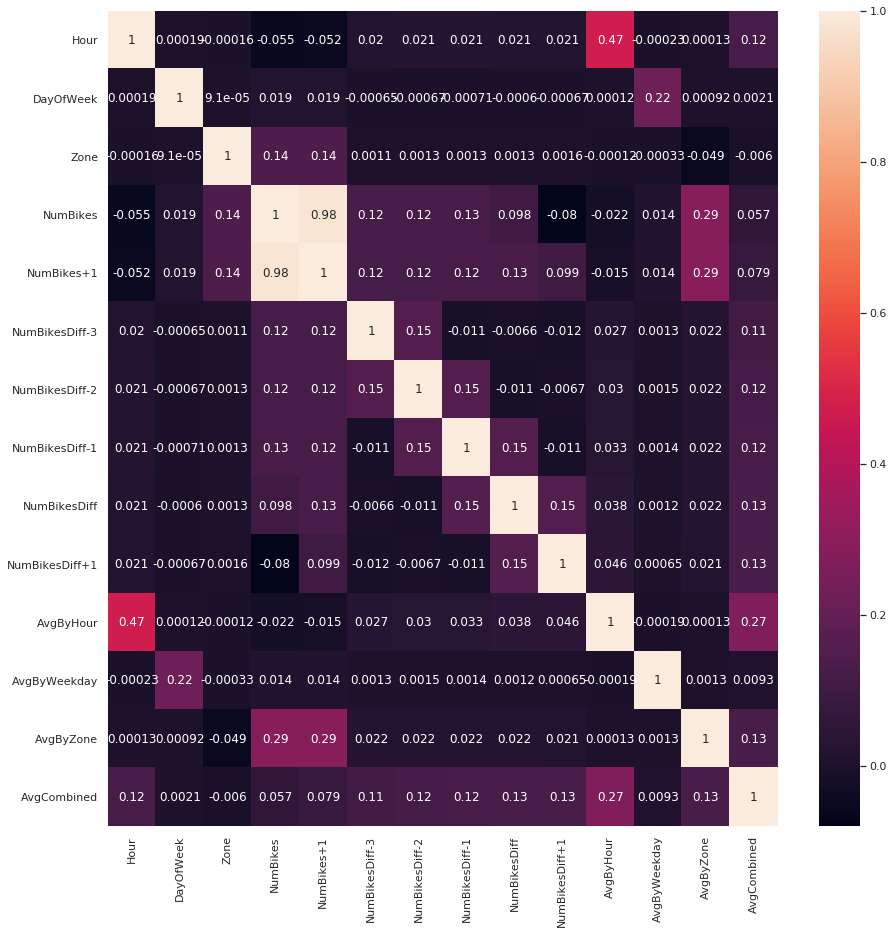

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrMatrix, annot=True, xticklabels=transformedTrainData.columns, yticklabels=transformedTrainData.columns, ax=ax);

## Output writing

Finally, we write the output datasets into an HDFS folder, from where they will be retrieved during the following steps.

In [17]:
outputPath = "/user/s291516/preprocessed/"

In [18]:
transformedTrainData \
    .coalesce(1) \
    .write \
    .format("csv") \
    .mode("overwrite") \
    .option("header", True) \
    .save(outputPath + "trainData/")

In [19]:
transformedTestData \
    .coalesce(1) \
    .write \
    .format("csv") \
    .mode("overwrite") \
    .option("header", True) \
    .save(outputPath + "testData/")